# TCS iON RIO 125 - Automate sentiment analysis of textual comments and feedback

Submitted by : Anagha Mohan

Date : October 2023

In [32]:
#pip install keras

In [2]:
#pip install tensorflow

Import necessary libraries and load the dataset

In [3]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

In [4]:
data = pd.read_csv('IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
data=data[0:25000]

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Data Preprocessing

In [7]:
data['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
24995    This movie was a real torture fest to sit thro...
24996    John Wayne & Albert Dekker compete for oil rig...
24997    Tarantino once remarked on a melodrama from th...
24998    Aah yes the workout show was a great. Not only...
24999    This film should have never been made. Honestl...
Name: review, Length: 25000, dtype: object

In [33]:
data.dtypes

review       object
sentiment    object
dtype: object

In [34]:
#Checking for null values
data.isna().sum()

review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

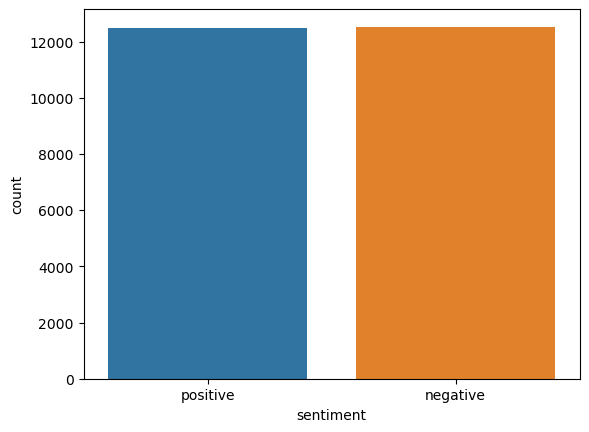

In [35]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=data)

# Data Preprocessing

In [13]:
# Convert text to lowercase
data['review'] = data['review'].str.lower()
data['review']

C:\Users\anagha mohan\AppData\Local\Temp\ipykernel_12572\3385387014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['review'].str.lower()


0        one reviewer mentioned watching 1 oz episode h...
1        a wonderful little production. <br /><br />the...
2        i thought wonderful way spend time hot summer ...
3        basically there's family little boy (jake) thi...
4        petter mattei's "love time money" visually stu...
                               ...                        
24995    this movie real torture fest sit through. its ...
24996    john wayne & albert dekker compete oil right i...
24997    tarantino remarked melodrama 1930s called back...
24998    aah yes workout show great. not many woman get...
24999    this film never made. honestly, i must admit i...
Name: review, Length: 25000, dtype: object

Remove stopwords from the corpus

In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to C:\Users\anagha
[nltk_data]     mohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\anagha mohan\AppData\Local\Temp\ipykernel_12572\3784704135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [16]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\anagha
[nltk_data]     mohan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Tokenization and lemmatization

In [17]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
data['review'] = data.review.apply(lemmatize_text)
data

C:\Users\anagha mohan\AppData\Local\Temp\ipykernel_12572\108191558.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data.review.apply(lemmatize_text)


,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production. <br /><br />the f...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there's family little boy (jake) thi...,negative
4,"petter mattei's ""love time money"" visually stu...",positive
...,...,...
24995,movie real torture fest sit through. first mis...,negative
24996,john wayne & albert dekker compete oil right i...,negative
24997,tarantino remarked melodrama 1930s called back...,positive
24998,aah yes workout show great. many woman get sha...,positive


In [20]:
s = 0.0
for i in data['review']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/data.shape[0])
pos = 0
for i in range(data.shape[0]):
    if data.iloc[i]['sentiment'] == 'positive':
        pos = pos + 1
neg = data.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/data.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/data.shape[0]*100)+"%")


Average length of each review :  127.43128
Percentage of reviews with positive sentiment is 49.896%
Percentage of reviews with negative sentiment is 50.104000000000006%


# Encoding Labels and Making Train-Test Splits

In [21]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [22]:
#split the dataset

In [23]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

Tokenizing and sequence padding

In [25]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# Building the model

In [26]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387601 (1.48 MB)
Trainable params: 387601 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Training and Evaluation

In [27]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
528/528 [==============================] - 197s 361ms/step - loss: 0.4748 - accuracy: 0.7746 - val_loss: 0.3819 - val_accuracy: 0.8459
Epoch 2/5
528/528 [==============================] - 186s 353ms/step - loss: 0.3211 - accuracy: 0.8728 - val_loss: 0.3756 - val_accuracy: 0.8421
Epoch 3/5
528/528 [==============================] - 187s 353ms/step - loss: 0.2640 - accuracy: 0.8970 - val_loss: 0.3345 - val_accuracy: 0.8608
Epoch 4/5
528/528 [==============================] - 185s 350ms/step - loss: 0.2176 - accuracy: 0.9183 - val_loss: 0.4093 - val_accuracy: 0.8373
Epoch 5/5
528/528 [==============================] - 174s 330ms/step - loss: 0.2328 - accuracy: 0.9067 - val_loss: 0.3862 - val_accuracy: 0.8395


In [28]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

196/196 [==============================] - 8s 37ms/step
Accuracy of prediction on test set :  0.84416


# Using the model to determine the sentiment of unseen movie reviews

In [30]:
# reviews on which we need to predict
sentence = ["This is a really good movie. I loved it and will watch again"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 [==============================] - 0s 23ms/step
This is a really good movie. I loved it and will watch again
Predicted sentiment :  Positive


In [31]:
import pickle

# Save the LSTM model to a pickle file
with open('lstm_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the tokenizer to a pickle file
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)
